




# Vision Transformer (ViT)
In this notebook you will use a pretrained Vision Transformer to predict a class
We won't train a model by ourself but rather use the power of freely available models which are pretrained by others on a large set of images (Imagenet
 14'197'122 images 1000 Classes). 

 There is  a library which provides us with the necessary models
 py**T**orch **IM**age **M**odels (timm):
 
https://github.com/huggingface/pytorch-image-models
https://huggingface.co/docs/hub/timm
 
 This notebook consist of the following steps:


1.   Download & set the weights to a given modelarchitecture
2.   Predict the class of an image with the model (likelihoods)
3.   Inspect the Key components of the Architecture


Imagenet: https://www.image-net.org/about.php

VisionTransformer: https://arxiv.org/abs/2010.11929

This notebook is adapted from https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb.

-------

In [7]:
#!pip install ipywidgets torchinfo 

import os
import requests
import ast

# PyTorch & timm
import numpy as np
import torch
import torch.nn.functional as F
from torchinfo import summary

import torchvision
import torchvision.transforms as T
from timm import create_model

# Displaying
from IPython.display import Image
from IPython.display import display as img_display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL


def load_labels(verbose=0):
  url = 'https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/main/notebooks/imagenet_labels.txt'
  response = requests.get(url)
  if response.status_code == 200:
      content = response.text
      try:
          # Use ast.literal_eval to safely parse the dictionary string
          imagenet_classes = ast.literal_eval(content)
          print("Dictionary loaded successfully!")
          if verbose ==1:
            for key in list(imagenet_classes.keys())[:5]:
                print(f"{key}: {imagenet_classes[key]}")
      except ValueError as e:
          print(f"Error parsing the content: {e}")
  display_options = [f"{index}: {name}" for index, name in imagenet_classes.items()]
  return display_options, imagenet_classes

display_options,imagenet_classes = load_labels(verbose=0)
class_dropdown = widgets.Dropdown(options=display_options,description='ImageNet Class:',)


# Optimized visualization function
def visualize_patches_optimized(i):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title("Visualization of Patches")
    ax.set_xticks([])
    ax.set_yticks([])
    grid = np.zeros((224, 224, 3))
    for j, patch in enumerate(patches):
        x = j % 14
        y = j // 14
        grid[y*16:(y+1)*16, x*16:(x+1)*16] = patch
    ax.imshow(grid)
    x = (i % 14) * 16
    y = (i // 14) * 16
    rect = plt.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.show()



Dictionary loaded successfully!


In [ ]:
!nvidia-smi

In [3]:
display(class_dropdown)

Dropdown(description='ImageNet Class:', options=('0: tench, Tinca tinca', '1: goldfish, Carassius auratus', '2…

Original size: (2592, 3888)
Resized size: (224, 224)


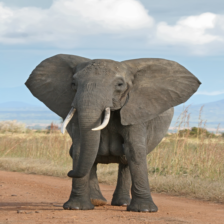

In [4]:
# Image URL
image_url = "https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/main/notebooks/African_Bush_Elephant.jpg"
#image_url ="https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true "
# Fetch the image
img = PIL.Image.open(requests.get(image_url, stream=True).raw)
print("Original size:", img.size)


IMG_SIZE = (224, 224)
transform = T.Compose([
    T.Resize(IMG_SIZE),  # Resizes the image
])
img_resized = transform(img)

print("Resized size:", img_resized.size)

img_resized

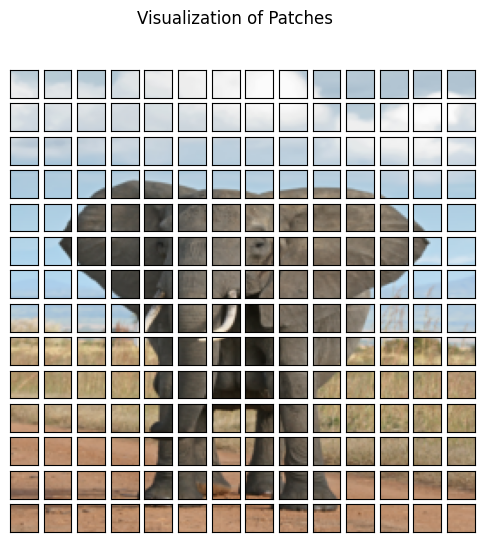

In [5]:
fig = plt.figure(figsize=(6, 6))
fig.suptitle("Visualization of Patches")
img_resized = np.asarray(img_resized)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img_resized[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_keras3/refs/heads/main/images/vit_overview.png" alt="Sample Image" width="1800">

In [6]:
#Load the model
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained=True).to(device)
print("Model Pretrained Configuration: " )
model.default_cfg

device =  cuda
Model Pretrained Configuration: 


{'url': '',
 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'architecture': 'vit_base_patch16_224',
 'tag': 'augreg2_in21k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        152,064
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       590,592
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               1,536
│    │    └─Attention: 3-2               2,362,368
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               1,536
│    │    └─Mlp: 3-6                     4,722,432
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               1,536
│    │    └─Attention: 3-10              2,362,368
│    │    └─Identity: 3-11     

lets make a prediciton for the elephant image we've put in

- we get the likelihoods for each of the classes 

In [8]:
# From the configuration, we can see that the model expects 224x224 and nomralized images mean 0.5 and std 0.5
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms_vit = [T.Resize(IMG_SIZE),T.ToTensor(),T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)]
preprocess_for_vit = T.Compose(transforms_vit)
img_tensor = preprocess_for_vit(img).unsqueeze(0).to(device)

# Inference with the model
z_scores=model(img_tensor)
probabilities = F.softmax(z_scores, dim=-1)



<img src="https://raw.githubusercontent.com/tensorchiefs/dl_keras3/refs/heads/main/images/encoder_overview.png" alt="Sample Image" width="1500">


In [9]:
k = 10
topk_probabilities, topk_indexes = torch.topk(probabilities, k=k, dim=-1)
topk_probabilities=topk_probabilities.detach().cpu().numpy().squeeze().tolist()
topk_indexes=topk_indexes.detach().cpu().numpy().squeeze().tolist()

import pandas as pd
data= pd.DataFrame({"Rank": list(range(1, k + 1)),"Class Index": topk_indexes,"Probability": topk_probabilities,"Class Description": [imagenet_classes.get(idx, "Unknown class") for idx in topk_indexes]})
data


,Rank,Class Index,Probability,Class Description
0,1,386,0.422192,"African elephant, Loxodonta africana"
1,2,101,0.400067,tusker
2,3,385,0.010720,"Indian elephant, Elephas maximus"
3,4,976,0.001569,"promontory, headland, head, foreland"
4,5,975,0.001348,"lakeside, lakeshore"
5,6,977,0.001244,"sandbar, sand bar"
6,7,979,0.001198,"valley, vale"
7,8,525,0.000858,"dam, dike, dyke"
8,9,974,0.000810,geyser
9,10,970,0.000749,alp


In [10]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


torch.Size([1, 197, 768])


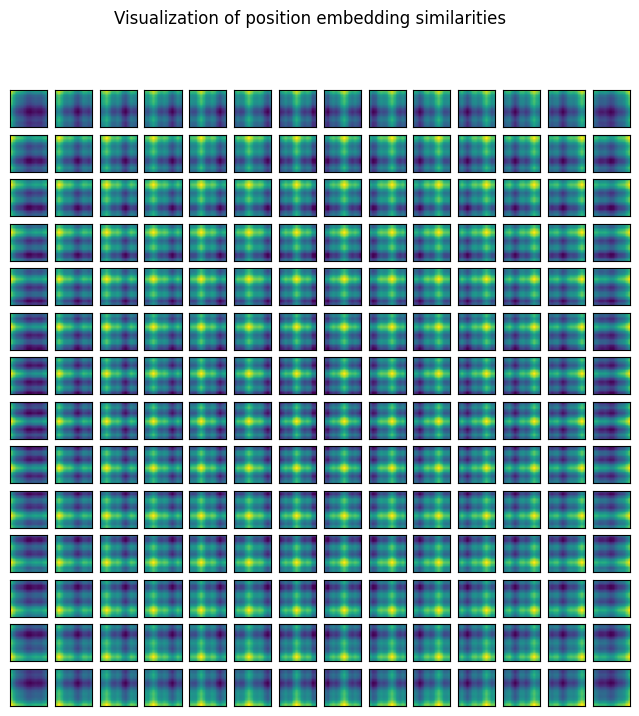

In [11]:
pos_embed = model.pos_embed
print(pos_embed.shape)

# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities")
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

In [12]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


In [13]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
    
    
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


In [14]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [15]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [16]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


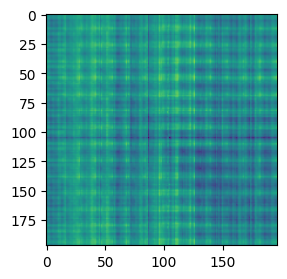

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.figure(figsize=(3, 3))
plt.imshow(attention_matrix[3].detach().cpu().numpy())

## Visualize attention

In [ ]:
# Preload the attention matrices for all blocks and heads
attention_heads=[]
for j in range(12):
    attention = model.blocks[j].attn
    transformer_input_expanded = attention.qkv(transformer_input)[0]
    qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
    q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
    k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
    kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
    attention_matrix = q @ kT
    attention_heads.append(attention_matrix)


# Create patchgrid for visualization of the orig image
img_resized_Sc = np.clip(img_resized, 0, 255) / 255.0  # Normalize to [0, 1]
patches = []
for j in range(196):
    x = j % 14
    y = j // 14
    patches.append(img_resized_Sc[y * 16:(y + 1) * 16, x * 16:(x + 1) * 16])
num_heads = attention_matrix.shape[0]  # Number of attention heads
rows = (num_heads + 1) // 4 + 1  # Calculate number of rows for subplot layout
# Create a grid to reconstruct the image from patches
grid = np.zeros((224, 224, 3))
for j, patch in enumerate(patches):
    x = j % 14
    y = j // 14
    grid[y * 16:(y + 1) * 16, x * 16:(x + 1) * 16] = patch



def visualize_patches_and_attention(i,j):
    """
    i: Patch index
    j: Block
    """
    # slected the encoder block
    attention_matrix = attention_heads[j]
    
    # Visualization of Attention Heatmaps
    fig = plt.figure(figsize=(8, rows * 2))
    fig.suptitle(f"Visualization of Attention Across All Heads for Patch {i+1}")

    # Display the small patch-reconstructed image in the top-left subplot
    ax = fig.add_subplot(rows, 4, 1)
    ax.imshow(grid)
    ax.axis("off")
    ax.set_title("Patch Image")

    # Highlight the selected patch in the grid
    patch_x = i % 14
    patch_y = i // 14
    rect = Rectangle((patch_x * 16, patch_y * 16), 16, 16, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Loop through all attention heads
    for head_idx in range(num_heads):
        # extract the attention heatmap for the selected patch i+1 since first is the token..
        attn_heatmap = attention_matrix[head_idx, i+1, 1:].reshape((14, 14)).detach().cpu().numpy()
        ax = fig.add_subplot(rows, 4, head_idx + 2)
        ax.imshow(attn_heatmap, cmap='viridis')
        rect = Rectangle((patch_x - 0.5, patch_y - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.axis("off")
        ax.set_title(f"Head {head_idx+1}")
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


# Create an interactive slider to select the patch index
patch = widgets.IntSlider(value=0, min=0, max=195, step=1, description="Patch nr")
block = widgets.IntSlider(value=0, min=0, max=len(attention_heads)-1, step=1, description="Block nr")
# Create an interactive plot
interactive_plot = widgets.interactive(visualize_patches_and_attention, i=patch,j=block)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Patch nr', max=195), IntSlider(value=0, description='Blo…